# 7 Solution Methods to Solve the Growth Model with Python

This notebook is part of a computational appendix that accompanies the paper

> MATLAB, Python, Julia: What to Choose in Economics?
> > Coleman, Lyon, Maliar, and Maliar (2017)

In order to run the codes in this notebook you will need to install and configure a few Python packages. We recommend downloading [Anaconda](https://www.continuum.io/downloads) and/or following the instructions on [quantecon.org](https://lectures.quantecon.org/py/getting_started.html). Once your Python installation is up and running, there are a few additional packages you will need in order to run the code here. To do this, you should remove the `# ` in front of the following commands and run the block below.

In [298]:
# ! pip install git+https://github.com/EconForge/interpolation.py.git
# ! pip install quantecon
# ! pip install csaps

In [299]:
import numpy as np
import scipy.linalg as la
import scipy.optimize as opt
import time
import quantecon as qe
import matplotlib.pyplot as plt

from collections import namedtuple
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.misc import derivative
from interpolation.complete_poly import (CompletePolynomial,
                                         n_complete, complete_polynomial,
                                         complete_polynomial_der,
                                         _complete_poly_impl,
                                         _complete_poly_impl_vec,
                                         _complete_poly_der_impl,
                                         _complete_poly_der_impl_vec)
from numba import jit, vectorize

## Model

This section gives a short description of the commonly used stochastic Neoclassical growth model.

There is a single infinitely-lived representative agent who consumes and saves using capital. The consumer discounts the future with factor $\beta$ and derives utility from only consumption. Additionally, saved capital will depreciate at $\delta$.

The consumer has access to a Cobb-Douglas technology which uses capital saved from the previous period to produce and is subject to stochastic productivity shocks.

Productivity shocks follow an AR(1) in logs.

The agent's problem can be written recursively using the following Bellman equation


$$
\begin{align}
  V(k_t, z_t) &= \max_{k_{t+1}} u(c_t) + \beta E \left[ V(k_{t+1}, z_{t+1}) \right] \\
  &\text{subject to } \\
  c_t &= z_t f(k_t) + (1 - \delta) k_t - k_{t+1} \\
  \log z_{t+1} &= \rho \log z_t + \sigma \varepsilon
\end{align}
$$

$$
\begin{align*}
    V(X, z) &= \max_{\tilde{c},\tilde{s}} \biggl\{0,  u(c) + \beta E \bigl[V(X', z') \bigr] \biggr\}\\
    & \text{ s.t. } \tilde{c} \geq 0; \qquad \tilde{s} \geq 0 \\
    & \phantom{\text{ s.t. } }N\tilde{c} + N\tilde{s} \leq X \\
    & \phantom{\text{ s.t. } } X' = \max \biggl\{0, \bigl[X - N\tilde{c}  - N\tilde{s} - z \bigl(\frac{\tilde{c}}{\tilde{s}}\bigr)^\phi \bigr](1 + g_x) \biggr\} \\
    & \phantom{\text{ s.t. } } u(\tilde{c}) = \bar{u} + \ln(\tilde{c}) \\
    & \phantom{\text{ s.t. } } z \sim Exp( \bar{z} ) 
\end{align*} 
$$

## Python Code

We begin by defining a `namedtuple` that contains the parameters of our model. This is useful to pass the parameters around to functions that are just-in-time (JIT) compiled by `numba`.

In [300]:
#
# Create a named tuple type that we can pass into the jitted functions
# so that we don't have to pass parameters one by one
#
Params = namedtuple("Params", ["N", "beta", "g", "a_bar", "eta", "u_bar"])

@jit(nopython=True)
def param_unpack(params):
    "Unpack parameters from the Params type"
    out = (params.N, params.beta, params.g,
           params.a_bar, params.eta, params.u_bar)

    return out

We will then define various helper functions to ensure that we [don't repeat ourselves](https://lectures.quantecon.org/py/writing_good_code.html#don-t-repeat-yourself) and that the inner functions can be JIT compiled.

In [301]:
#
# Helper functions to make sure things are jitted
#
@vectorize(nopython=True)
def u(c, eta, u_bar):
    "log utility function"
    return -1e10 if c < 1e-10 else (u_bar + np.log(c)) if eta==1 else (u_bar + (c**(1-eta)/(1-eta)))

@vectorize(nopython=True)
def du(c,eta):
    "Derivative of log utility function"
    return 1e10 if c < 1e-10 else c**(-eta)

@vectorize(nopython=True)
def duinv(u,eta):
    "Inverse of the derivative of the CRRA utility function"
    return u**(-1.0/eta )

@vectorize(nopython=True)
def f(X):
    "production function"
    return X

@vectorize(nopython=True)
def df(X):
    "Derivative of production function"
    return 1

@vectorize(nopython=True)
def discount_factor(beta, a_bar, c, w):
    "risk adjusted discount factor"
    return beta*a_bar*w/(c + a_bar*w)

@vectorize(nopython=True)
def next_x(X, N, g, c, w):
    # next period's CPR given c and w
    return (X - N*(c + w))*(1+g)

@vectorize(nopython=True)
def vector_dampen(vec1, vec2, dampen=1):
    return dampen*vec1 + (1-dampen)*vec2

@vectorize(nopython=True)
def trunc_to_one(X):
    return X if X >= 1 else 1

@vectorize(nopython=True)
def vf_curve_vec(x, a, b, c, d):
    return a + (b/(1 - x**(-c)))*np.log(d*x)

def vf_curve(x, a, b, c):
    return a + (b/(1 - x**(-c)))*np.log(x)

@vectorize(nopython=True)
def cw_curve_vec(x, a, b, c, d):
    return a*np.log(x) + b*(x**c) + d

def cw_curve(x, a, b, c):
    return a*np.log(x)*(x**b) + c

This code block contains other functions that are useful for computing the policy using the envelope condition (to be discussed later), simulating, and computing Euler errors.

In [302]:
@jit(nopython=True)
def env_cond_kp(temp, params, degree, v_coeffs, Xt):
    # Unpack parameters
    N, beta, g, a_bar, eta, u_bar = param_unpack(params)

    # Compute derivative of VF wrt k
    _complete_poly_der_impl_vec(np.array([Xt, zt]), degree, 0, temp)

    c = duinv(np.dot(temp, v_coeffs) / (1/N))

    return expendables_t(Xt) - c


@jit(nopython=True)
def jit_simulate_ncgm(params, degree, v_coeffs, T, nburn, shocks):
    "Simulates economy using envelope condition as policy rule"
    # Unpack parameters
    N, beta, g, a_bar, eta, u_bar = param_unpack(params)

    # Allocate space for output
    xsim = np.empty(T+nburn)
    zsim = np.empty(T+nburn)
    xsim[0], zsim[0] = 1.0, 1.0 # may need to modify initial values

    # Allocate space for temporary vector to fill with complete polynomials
    temp = np.empty(n_complete(2, degree))

    # Simulate
    for t in range(1, T+nburn):
        # Evaluate policy for today given yesterdays state
        xp = env_cond_kp(temp, params, degree, v_coeffs, xsim[t-1], zsim[t-1])
        
        # Draw new z and update k using policy from above
        zsim[t] = shocks[t]
        xsim[t] = kp

    return xsim[nburn:], zsim[nburn:]


@jit(nopython=True)
def jit_ee(params, degree, v_coeffs, nodes, weights, xs, zs):
    # Unpack parameters
    N, beta, g, a_bar, eta, u_bar = param_unpack(params)

    # Allocate space for temporary vector to fill with complete polynomials
    temp = np.empty(n_complete(2, degree))
    T = xs.size
    Qn = weights.size

    # Allocate space to store euler errors
    ee = np.empty(T)

    # Iterate over all ks and zs
    for t in range(T):
        # Current states
        x, z = xs[t], zs[t]

        # Compute decision for kp and implied c
        x1 = env_cond_kp(temp, params, degree, v_coeffs, x, z)
        c = expendables_t(k, z, A, alpha, delta) - k1

        # Compute euler error for period t
        lhs = du(c, gamma)
        rhs = 0.0
        for i in range(Qn):
            # Get productivity tomorrow
            z1 = z**rho * np.exp(nodes[i])

            # Compute decision for kpp and implied c
            k2 = env_cond_kp(temp, params, degree, v_coeffs, k1, z1)
            c1 = expendables_t(k1, z1, A, alpha, delta) - k2
            rhs = rhs + weights[i]*du(c1, gamma)*(1-delta+df(k1, z1, A, alpha))

        ee[t] = np.abs(1.0 - beta*rhs/lhs)

    return ee


We also now define a class that contains

1. Parameters of the growth model
2. Grids used for approximating the solution
3. Nodes and weights used to approximate integration

This again helps us maintain all of the relevant information in one place and simplifies passing it to other functions.

In [303]:
class Model(object):
    """
    The stochastic Neoclassical Growth model contains
    parameters which include

    * alpha: Capital share in output
    * beta: discount factor
    * delta: depreciation rate
    * gamma: risk aversion
    * rho: persistence of the log productivity level
    * sigma: standard deviation of shocks to log productivity
    """
    def __init__(self, N=2, beta=0.9, g_x=0.005, g_a=0.015, a_bar=1000, 
                 eta=1, u_bar=0, 
                 xmin=50, xmax=2000, nx=15):
        # calculate g from g_a and g_x 
        g = g_a + g_x + g_a*g_x

        # Household parameters
        self.beta, self.eta, self.u_bar, = beta, eta, u_bar

        # Firm/technology parameters
        self.N, self.g, self.a_bar = N, g, a_bar

        # Create t grids
        self.xgrid = N*np.linspace(xmin,xmax,nx)
#         self.logxgrid = np.log(self.xgrid)
#         self.grid = np.column_stack((self.xgrid, self.logxgrid ))
        self.grid = np.reshape(self.xgrid, [self.xgrid.shape[0], 1])
#         self.grid = np.reshape(self.logxgrid, [self.logxgrid.shape[0], 1])

        self.ns = self.xgrid.shape[0]
        
    def _unpack_params(self):
        out = (self.N, self.beta, self.g, 
               self.a_bar, self.eta, self.u_bar)
        return out

    def _unpack_grids(self):
        out = (self.xgrid, self.grid)
        return out


## Solution Methods

In this notebook, we describe the following solution methods:

* Conventional Value Function Iteration
* Envelope Condition Value Function Iteration
* Envelope Condition Derivative Value Function Iteration
* Endogenous Grid Value Function Iteration
* Conventional Policy Function Iteration
* Envelope Condition Policy Function Iteration
* Euler Equation Method

Each of these solution methods will have a very similar structure that follows a few basic steps:

1. Guess a function (either value function or policy function).
2. Using this function, update our guess of both the value and policy functions.
3. Check whether the function we guessed and what it was updated to are similar enough. If so, proceed. If not, return to step 2 using the updated functions.
4. Output the policy and value functions.

In order to reduce the amount of repeated code and keep the exposition as clean as possible (the notebook is plenty long as is...), we will define a class for each solution method that inherit various properties from a general solution parent class. The parent class will contain methods which apply to all of the other solution methods such as a general solve method, computing expectations, simulating, etc... This implementation may feel strange at first if one isn't familiar with object oriented programming, but these concepts can be powerful when properly used.

In [304]:
class GeneralSolution:
    """
    This is a general solution method. We define this, so that we can
    sub-class it and define specific update methods for each particular
    solution method
    """
    def __init__(self, ncgm, dx=1e-6, maxfev=10000, prev_sol=None):
        # Save model and approximation degree
        self.ncgm, self.dx, self.maxfev = ncgm, dx, maxfev

        # Unpack some info from ncgm
        N, beta, g, a_bar, eta, u_bar = self._unpack_params()
        grid = self.ncgm.grid
        X = self.ncgm.xgrid

        # Use parameter values from model to create a namedtuple with
        # parameters saved inside
        self.params = Params(N, beta, g, a_bar, eta, u_bar)

#         self.Phi = complete_polynomial(grid.T, degree).T
#         self.dPhi = complete_polynomial_der(grid.T, degree, 0).T

        # Update to fill initial value and policy matrices
        # If we give it another solution type then use it to
        # generate values and policies
        if issubclass(type(prev_sol), GeneralSolution):
#             oldPhi = complete_polynomial(ncgm.grid.T, prev_sol.degree).T
#             self.CP = oldPhi @ prev_sol.c_coeffs
#             self.WP = oldPhi @ prev_sol.w_coeffs
#             self.VF = oldPhi @ prev_sol.v_coeffs
            self.CP = cw_curve(X, *prev_sol.c_params)
            self.WP = cw_curve(X, *prev_sol.w_params)
            self.VF = vf_curve(X, *prev_sol.v_params)
        # If we give it a tuple then assume it is (policy, value) pair
        elif type(prev_sol) is tuple:
            self.CP = prev_sol[0]
            self.WP = prev_sol[1]
            self.VF = prev_sol[2]
        # Otherwise guess a constant value function and a policy
        # of roughly steady state
        else:
            # guess VF
            self.VF = X # np.ones(ncgm.ns)
            
            # make a guess
            self.CP = X/(4*N)
            self.WP = X/(4*N)


        # Coefficients based on guesses
#         self.c_coeffs = la.lstsq(self.Phi, self.CP)[0]
#         self.w_coeffs = la.lstsq(self.Phi, self.WP)[0]
#         self.v_coeffs = la.lstsq(self.Phi, self.VF)[0]
        self.c_params, _ = opt.curve_fit(cw_curve, X, self.CP, maxfev=self.maxfev)
        self.w_params, _ = opt.curve_fit(cw_curve, X, self.WP, maxfev=self.maxfev)
        self.v_params, _ = opt.curve_fit(vf_curve, X, self.VF, maxfev=self.maxfev)

    def _unpack_params(self):
        return self.ncgm._unpack_params()

    def build_VF(self):
        """
        Using the current coefficients, this builds the value function
        for all states
        """
#         VF = self.Phi @ self.v_coeffs
        VF = vf_curve(self.ncgm.xgrid, *self.v_params)

        return VF

    def build_CP(self):
        """
        Using the current coefficients, this builds the policy function
        for all states
        """
        CP = cw_curve(self.ncgm.xgrid, *self.c_params)

        return CP
    
    def build_WP(self):
        """
        Using the current coefficients, this builds the policy function
        for all states
        """
        WP = cw_curve(self.ncgm.xgrid, *self.w_params)

        return WP

    def update_v(self, new_v_params, dampen=1):
        """
        Updates the coefficients for the value function
        """
#         self.v_coeffs = (1-dampen)*self.v_coeffs + dampen*new_v_coeffs
        self.v_params = (1-dampen)*self.v_params + dampen*new_v_params

        return None

    def update_c(self, new_c_params, dampen=1):
        """
        Updates the coefficients for the policy function
        """
#         self.c_coeffs = (1-dampen)*self.c_coeffs + dampen*new_c_coeffs
        self.c_params = (1-dampen)*self.c_params + dampen*new_c_params

        return None
    
    def update_w(self, new_w_params, dampen=1):
        """
        Updates the coefficients for the policy function
        """
#         self.w_coeffs = (1-dampen)*self.w_coeffs + dampen*new_w_coeffs
        self.w_params = (1-dampen)*self.w_params + dampen*new_w_params

        return None

    def update(self):
        """
        Given the current state of everything in solution, update the
        value and policy coefficients
        """
        emsg = "The update method is implemented in solution specific classes"
        emsg += "\nand cannot be called from `GeneralSolution`"
        raise ValueError(emsg)

    def compute_coefficients(self, cp, wp, VF):
        """
        Given a policy and value return corresponding coefficients
        """
        new_c_coeffs = la.lstsq(self.Phi, cp)[0]
        new_w_coeffs = la.lstsq(self.Phi, wp)[0]
        new_v_coeffs = la.lstsq(self.Phi, VF)[0]

        return new_c_coeffs, new_w_coeffs, new_v_coeffs
    
    def compute_params(self, cp, wp, VF):
        new_c_params, _ = opt.curve_fit(cw_curve, self.ncgm.xgrid, cp, maxfev=self.maxfev)
        new_w_params, _ = opt.curve_fit(cw_curve, self.ncgm.xgrid, wp, maxfev=self.maxfev)
        new_v_params, _ = opt.curve_fit(vf_curve, self.ncgm.xgrid, VF, maxfev=self.maxfev) 
        
        return new_c_params, new_w_params, new_v_params

    def compute_EV_scalar(self, Xn):
#         phi = complete_polynomial(np.vstack([np.log(trunc_to_one(Xn))]), self.degree).T
#         val = (phi@self.v_coeffs)[0]

        val = vf_curve(trunc_to_one(Xn), *self.v_params)
        
        return val

    def compute_dEV_scalar(self, Xn):
#         dphi = complete_polynomial_der(np.vstack([np.log(trunc_to_one(Xn))]), self.degree,0).T/trunc_to_one(Xn)
#         val = (dphi@self.v_coeffs)[0]

        vf_curve_curried = lambda x: vf_curve(x, *self.v_params)
        val = derivative( vf_curve_curried, trunc_to_one(Xn), self.dx)
        
        return val 

    def compute_EV(self, Xn=None):
        """
        Compute the expected value
        """

        # Use policy to compute cp and wp
        if Xn is None:
            # Unpack parameters
            N, beta, g, a_bar, eta, u_bar = self._unpack_params()
            X = self.ncgm.xgrid
#             cp = self.Phi @ self.c_coeffs
#             wp = self.Phi @ self.w_coeffs
            cp = cw_curve(X, *self.c_params)
            wp = cw_curve(X, *self.w_params)
            Xn = next_x(X, N, g, cp, wp)
                
#         Phi = complete_polynomial(np.vstack([np.log(trunc_to_one(Xn))]), self.degree).T
#         EV = Phi @ self.v_coeffs

        EV = vf_curve(trunc_to_one(Xn), *self.v_params)
        
        return EV


    def compute_dEV(self, Xn=None):
        """
        Compute the derivative of the expected value
        """
        # Use policy to compute cp and wp
        if Xn is None:
            # Unpack parameters
            N, beta, g, a_bar, eta, u_bar = self._unpack_params()
            X = self.ncgm.xgrid
#             cp = self.Phi @ self.c_coeffs
#             wp = self.Phi @ self.w_coeffs
            cp = cw_curve(X, *self.c_params)
            wp = cw_curve(X, *self.w_params)
            Xn = next_x(X, N, g, cp, wp)
        
#         dPhi = complete_polynomial_der(np.vstack([np.log(trunc_to_one(Xn))]), self.degree).T/trunc_to_one(Xn)
        
#         dEV = dPhi @ self.v_coeffs
        vf_curve_curried = lambda x: vf_curve(x, *self.v_params)
        val = derivative( vf_curve_curried, trunc_to_one(Xn), self.dx)
        
        return dEV

    def envelope_policy(self):
        """
        Applies the envelope condition to compute the policy for
        k_{t+1} at every point on the grid
        """
        # Unpack parameters
        A, alpha, beta, delta, gamma, rho, sigma = self._unpack_params()
        grid = self.ncgm.grid
        k, z = grid[:, 0], grid[:, 1]

        dV = self.dPhi@self.v_coeffs

        # Compute the consumption
        temp = dV / (1 - delta + df(k, z, A, alpha))
        c = duinv(temp, gamma)

        return expendables_t(k, z, A, alpha, delta) - c

    def compute_distance(self, cp, wp, VF):
        """
        Computes average distance between policy functions
        """
        return np.max([
            np.max(np.abs(1.0 - (cp+1e-12)/(self.CP+1e-12))), 
            np.max(np.abs(1.0 - (wp+1e-12)/(self.WP+1e-12)))
        ])
    

    def solve(self, tol=1e-3, maxiter=2500, verbose=False, nskipprint=25):
        # Iterate until convergence
        dist, it = 10.0, 0
        while (dist>tol) and (it<maxiter):
            # Run solution specific update code
            cp, wp, VF = self.update()

            # Compute new policy and value coeffs
            new_c_params, new_w_params, new_v_params = self.compute_params(cp, wp, VF)

            # Update distance and iterations
            dist = self.compute_distance(cp, wp, VF)
            self.CP, self.WP, self.VF = cp, wp, VF
            it += 1
            if verbose and it%nskipprint == 0:
                print(it, dist)

#             # Update all coefficients
            self.update_c(new_c_params)
            self.update_w(new_w_params)
            self.update_v(new_v_params)

        # After finishing iteration, iterate to convergence using policy
        if not isinstance(self, IterateOnPolicy):
            sol_iop = IterateOnPolicy(self.ncgm, self.dx, self.maxfev, self)
            cp, wp, VF = sol_iop.solve(tol=1e-3)

            # Save final versions of everything
            self.CP, self.WP, self.VF = cp, wp, VF
            
            new_c_params, new_w_params, new_v_params = sol_iop.compute_params(cp, wp, VF)
            self.update_c(new_c_params)
            self.update_w(new_w_params)
            self.update_v(new_v_params)

        return self.CP, self.WP, self.VF

    def simulate(self, T=10000, nburn=200, shocks=None, seed=42):
        """
        Simulates the neoclassical growth model with policy function
        given by self.KP. Simulates for `T` periods and discarsd first
        nburn `observations`
        """
        if shocks is None:
            np.random.seed(seed)
            shocks = np.random.exponential(self.z_bar, T+nburn)

        return jit_simulate_ncgm(self.params, self.degree, self.v_coeffs,
                                 T, nburn, shocks)

    def ee_residuals(self, ksim=None, zsim=None, Qn=10, seed=42):
        """
        Computes the Euler Equation residuals of a simulated capital and
        productivity levels (ksim and zsim) and uses Qn nodes for computing
        the expectation
        """
        if (ksim is None) or (zsim is None):
            ksim, zsim = self.simulate(T=10000, nburn=200, seed=seed)

        nodes, weights = qe.quad.qnwnorm(Qn, 0.0, self.ncgm.sigma**2)
        ee = jit_ee(self.params, self.degree, self.v_coeffs,
                    nodes, weights, ksim, zsim)

        return np.log10(np.mean(ee)), np.log10(np.max(ee))

### Iterating to Convergence (given policy)

This isn't one of the methods described above, but it is used as an element of a few of our methods (and also as a way to get a first guess at the value function). This method takes an initial policy function, $\bar{k}(k_t, z_t)$, as given, and then, without changing the policy, iterates until the value function has converged.

Thus the "update section" of the algorithm in this instance would be:

* Leave policy function unchanged
* At each point of grid, $(k_t, z_t)$, compute $\hat{V}(k_t, z_t) = u(c(\bar{k}(k_t, z_t))) + \beta E \left[ V(\bar{k}(k_t, z_t), z_{t+1}) \right]$

We override two of the methods from `GeneralSolution`

* `compute_distance` because when we are iterating to convergence on the value function we want to check distnace using value function rather than policy function
* `compute_coefficients` because we don't need to update the policy functions coefficients.

The `update` method just repeatedly applies a particular policy function to update the value function.

In [305]:
class IterateOnPolicy(GeneralSolution):
    """
    Subclass of the general solution method. The update method for this
    class simply computes the fixed point of the value function given
    a specific policy
    """
    def compute_distance(self, cp, wp, VF):
        """
        Computes distance between policy functions. When we are
        iterating on a specific policy, we would like to compute
        distances by the difference between VFs
        """
        return np.max(np.abs(1.0 - (VF )/(self.VF )))

    def compute_coefficients(self, cp, wp, VF):
        """
        Given a policy and value return corresponding coefficients.
        When we are iterating on a specific policy, we don't want to
        update the policy coefficients.
        """
        new_v_coeffs = la.lstsq(self.Phi, VF)[0]

        return self.c_coeffs, self.w_coeffs, new_v_coeffs
    
    def compute_params(self, cp, wp, VF):
        new_v_params, _ = opt.curve_fit(vf_curve, self.ncgm.xgrid, VF, maxfev=self.maxfev) 
        
        return self.c_params, self.w_params, new_v_params
    
    def update(self):
        # Unpack parameters
        N, beta, g, a_bar, eta, u_bar = self._unpack_params()
        X = self.ncgm.xgrid
        
        Xn = next_x(X, N, g, self.CP, self.WP)

#         Update the value function
        VF = u(self.CP, eta, u_bar) + beta*np.maximum(self.compute_EV(Xn), np.zeros(self.ncgm.ns))
#         VF = u(self.CP, eta, u_bar) + beta*self.compute_EV(Xn)

        return self.CP, self.WP, VF

### Conventional Value Function Iteration

This is one of the first solution methods for macroeconomics a graduate student in economics typically learns.

In this solution method, one takes as given a value function, $V(k_t, z_t)$, and then solves for the optimal policy given the value function.

The update section takes the form:

* For each point, $(k_t, z_t)$, numerically solve for $c^*(k_t, z_t)$ to satisfy the first order condition $u'(c^*) = \beta E \left[ V_1((1 - \delta) k_t + z_t f(k_t) - c^*, z_{t+1}) \right]$
* Define $k^*(k_t, z_t) = (1 - \delta) k_t + z_t f(k_t) - c^*(k_t, z_t)$
* Update value function according to $\hat{V}(k_t, z_t) = u(c^*(k_t, z_t)) + \beta E \left[ V(k^*(k_t, z_t), z_{t+1}) \right]$


* For each point, $(X_t, z_t)$, numerically solve for $c^*(X_t, z_t)$ to satisfy the first order condition $u'(\tilde{c}^\ast) = \beta E \left[ V_1((1 - \delta) k_t + z_t f(k_t) - c^*, z_{t+1}) \right]$
* Define $k^*(k_t, z_t) = (1 - \delta) k_t + z_t f(k_t) - c^*(k_t, z_t)$
* Update value function according to $\hat{V}(k_t, z_t) = u(c^*(k_t, z_t)) + \beta E \left[ V(k^*(k_t, z_t), z_{t+1}) \right]$




In [306]:
class VFI(GeneralSolution):
    """
    Updates the coefficients and value functions using the VFI
    method
    """
    def update(self):
        """
        Updates the coefficients and value functions using the VFI_ECM
        method
        """
        # Unpack parameters
        N, beta, g, a_bar, eta, u_bar = self._unpack_params()
        xgrid = self.ncgm.xgrid
        n_state = xgrid.shape[0]

        # Get the policy and update it
        cp = np.empty(n_state)
        wp = np.empty(n_state)
        VF = np.empty(n_state)
        for i_s in range(n_state):
            # Pull out current vals
            X = xgrid[i_s]
            
            # objective function to minimize 
            def _f(CW):
                c = CW[0]
                w = CW[1]
                
                Xn = next_x(X, N, g, c, w)
                EV = self.compute_EV_scalar(Xn)
                dEV = self.compute_dEV_scalar(Xn)
                
                return (
                    du(c, eta) - (beta*a_bar*w/(c + a_bar*w))*(EV/(c + a_bar*w) + N*(1+g)*dEV)
                )**2 + (
                    (c/(c + a_bar*w))*EV - w*N*(1+g)*dEV
                )**2
                 
            
            A=[[1,1],[1,0],[0,1]]
            lbnd=1e-6
            upbnd=X/N
            x0 = [X/(4*N),X/(4*N)]
            
            cons = opt.LinearConstraint(A, lbnd, upbnd)
            
            # minimize objective
            [_cp, _wp] = opt.minimize(_f, x0,constraints=cons, method='COBYLA').x
            
            Xn = next_x(X, N, g, _cp, _wp)
            Xn = trunc_to_one(Xn)
            EV = self.compute_EV_scalar(Xn)
            
            VF_corner = u(X/N, eta, u_bar)
            VF_interior = u(_cp, eta, u_bar)+beta*EV
            
            if VF_corner > VF_interior:
                cp[i_s] = X/N
                wp[i_s] = 0
                VF[i_s] = VF_corner
            else:                
                cp[i_s] = _cp
                wp[i_s] = _wp
                VF[i_s] = VF_interior

        return cp, wp, VF


In [307]:
class find_thresh(GeneralSolution):
    """
    Updates the coefficients and value functions using the VFI
    method
    """
    def get_threshold(self):
        """
        Updates the coefficients and value functions using the VFI_ECM
        method
        """
        # Unpack parameters
        N, beta, g, a_bar, eta, u_bar = self._unpack_params()
        grid = self.ncgm.grid
        n_state = grid.shape[0]

        # Get the policy and update it
        cp = np.empty(n_state)
        wp = np.empty(n_state)
        VF = np.empty(n_state)
        for i_s in range(n_state):
            # Pull out current vals
            X = self.ncgm.xgrid
            
            # objective function to minimize 
            def _f(CW):
                c = CW[0]
                w = CW[1]
                
                Xn = next_x(X, N, g, c, w)
                Xn = trunc_to_one(Xn)
                
                return (
                    du(c, eta) - beta*((a_bar*w)/(c + a_bar*w))*(
                        u(Xn/N, eta, u_bar)/(c + a_bar*w)
                        + (1 + g)*du(Xn/N, eta)
                    )
                )**2 + (
                    (c/(c + a_bar*w))*u(Xn/N, eta, u_bar)
                    - w*(1 + g)*du(Xn/N, eta)
                )**2

            
            A=[[1,1],[1,0],[0,1]]
            lbnd=1e-6
            upbnd=X/N
            x0 = [0.01,0.01]
            
            cons = opt.LinearConstraint(A, lbnd, upbnd)
            
            # minimize objective
            [_cp, _wp] = opt.minimize(_f, x0, constraints=cons).x
            
            Xn = next_x(X, N, g, _cp, _wp)
            Xn = trunc_to_one(Xn)
            VF_interior = u(_cp, eta, u_bar) + beta*(a_bar*_wp/(_cp + a_bar*_wp))*u(Xn/N, eta, u_bar)
            
            VF_corner = u(X/N, eta, u_bar)
            
            if VF_corner > VF_interior:
                cp[i_s] = X/N
                wp[i_s] = 0
                VF[i_s] = VF_corner
            else:                
                cp[i_s] = _cp
                wp[i_s] = _wp
                VF[i_s] = VF_interior

        return cp, wp, VF

    


## A Horse Race

We can now run a horse race to compare the methods in terms of both accuracy and speed.

In [308]:
ncgm = Model(N=10)

# First guess
vp = IterateOnPolicy(ncgm, maxfev=50000)
vp.solve(tol=1e-9)

np.random.seed(61089)


print('vp done')
# degree 2 VFI:
dx=1e-6
new_sol = vp
new_sol = VFI(ncgm, dx=dx, maxfev=50000, prev_sol=new_sol)
ts = time.time()
new_sol.solve(tol=1e-2, verbose=True, nskipprint=25)
time_took = time.time() - ts

<ipython-input-301-24cae04dc652>:52: RuntimeWarning: overflow encountered in power
  return a + (b/(1 - x**(-c)))*np.log(x)
<ipython-input-301-24cae04dc652>:52: RuntimeWarning: overflow encountered in power
  return a + (b/(1 - x**(-c)))*np.log(x)
/Users/mikemahon/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


vp done


/Users/mikemahon/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [309]:
X = new_sol.ncgm.xgrid
X

array([  500.        ,  1892.85714286,  3285.71428571,  4678.57142857,
        6071.42857143,  7464.28571429,  8857.14285714, 10250.        ,
       11642.85714286, 13035.71428571, 14428.57142857, 15821.42857143,
       17214.28571429, 18607.14285714, 20000.        ])

In [310]:
VF = new_sol.VF
VF

array([ 9.20771025, 19.79826686, 24.36088974, 27.33706052, 29.55641599,
       31.32966062, 32.80791634, 34.07631796, 35.18764331, 36.1769048 ,
       37.06853624, 37.88027385, 38.62540442, 39.31414192, 39.95450918])

In [311]:
new_sol.build_VF()

array([ 9.17868133, 19.80955255, 24.3775719 , 27.35225724, 29.56868103,
       31.33874511, 32.81390638, 34.07939611, 35.18801154, 36.17475802,
       37.06405376, 37.87361754, 38.61671942, 39.30355812, 39.94214299])

In [312]:
CP = new_sol.CP
CP

array([  7.06544758,  37.43986173,  68.04324937,  98.64941968,
       129.2172783 , 159.73541769, 190.20101698, 220.61432561,
       250.97677988, 281.29025835, 311.55676176, 341.77827019,
       371.95667992, 402.09377799, 432.1912351 ])

In [313]:
new_sol.build_CP()

array([  7.06544758,  37.43986173,  68.04324937,  98.64941968,
       129.2172783 , 159.73541769, 190.20101698, 220.61432561,
       250.97677988, 281.29025835, 311.55676176, 341.77827019,
       371.95667992, 402.09377799, 432.1912351 ])

In [314]:
WP = new_sol.WP
WP

array([ 0.47852874,  3.45316122,  6.73206371, 10.17266965, 13.72493909,
       17.36270108, 21.06978096, 24.8351713 , 28.65089024, 32.51088219,
       36.41039446, 40.34559703, 44.31333735, 48.31097504, 52.33626633])

In [315]:
new_sol.build_WP()

array([ 0.47852874,  3.45316122,  6.73206371, 10.17266965, 13.72493909,
       17.36270108, 21.06978096, 24.8351713 , 28.65089024, 32.51088219,
       36.41039446, 40.34559703, 44.31333735, 48.31097504, 52.33626633])

In [316]:
CP/WP

array([14.76493891, 10.84219916, 10.1073389 ,  9.69749565,  9.41477973,
        9.19991751,  9.02719479,  8.88314089,  8.75982484,  8.6521878 ,
        8.5568082 ,  8.47126565,  8.39378621,  8.32303173,  8.25796843])

In [317]:
c0 = cw_curve(274, *new_sol.c_params)
w0 = cw_curve(274, *new_sol.w_params)

c0/w0

m0 = 1000*w0/(c0 + 1000*w0)
1 - m0

0.03580457737934595

<ipython-input-301-24cae04dc652>:52: RuntimeWarning: divide by zero encountered in true_divide
  return a + (b/(1 - x**(-c)))*np.log(x)
<ipython-input-301-24cae04dc652>:52: RuntimeWarning: invalid value encountered in multiply
  return a + (b/(1 - x**(-c)))*np.log(x)


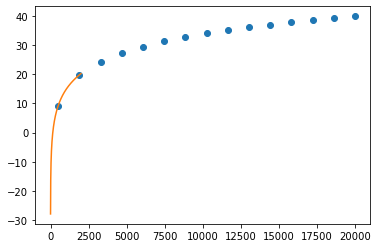

In [318]:
xnew = np.arange(1,2e3,1)
# logxnew = np.log(xnew)
# logxnew_grid = np.reshape(logxnew, [logxnew.shape[0], 1])
# Phi = complete_polynomial(logxnew_grid.T, new_sol.degree).T
# vf_new = Phi @ v_coef
vf_new = vf_curve(xnew, *new_sol.v_params)

plt.plot(X, VF, 'o', xnew, vf_new)

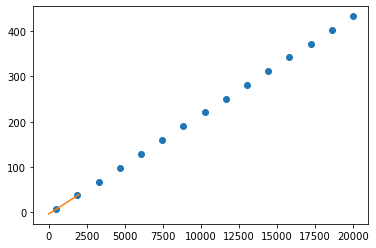

In [319]:
# cp_new = Phi @ new_sol.c_coeffs
cp_new = cw_curve(xnew, *new_sol.c_params)

plt.plot(X, CP, 'o', xnew, cp_new)

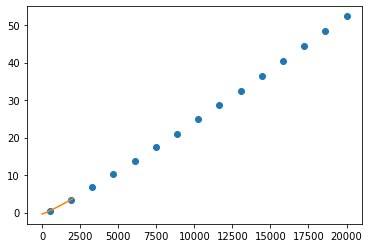

In [320]:
# wp_new = Phi @ new_sol.w_coeffs
wp_new = cw_curve(xnew, *new_sol.w_params)

plt.plot(X, WP, 'o', xnew, wp_new)

In [321]:
cp_new/wp_new

array([ 8.99596353,  8.98168371,  8.96441094, ..., 10.76357112,
       10.76284539, 10.7621202 ])